Glasses or no glasses

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random

## Glasess:

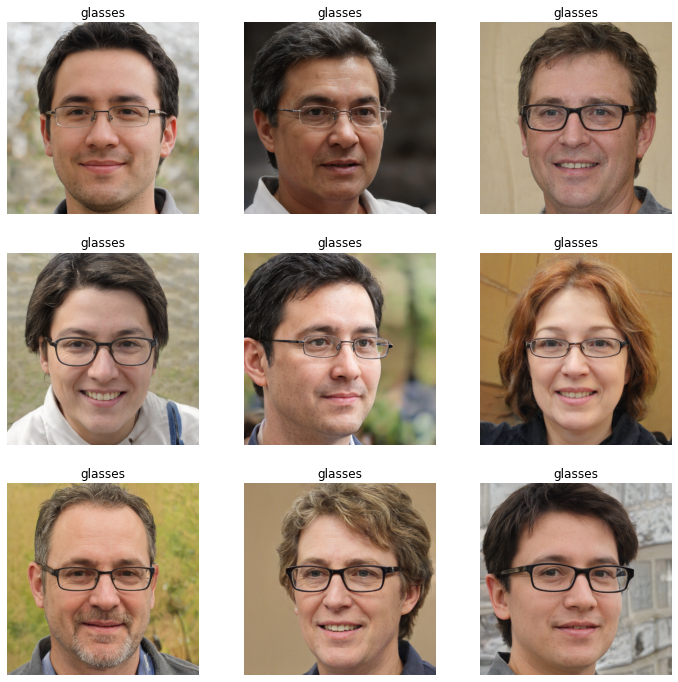

In [ ]:
with open("../input/datacleaningglassesnoglasses/glasses.txt", "rb") as fp:
    glasses = pickle.load(fp)
plt.figure(figsize=(12, 12))
ran_num = []
for i in range(0,9):
    n = random.randint(0,len(glasses))
    ran_num.append(n)
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(glasses[ran_num[i]]))
    plt.title("glasses")
    plt.axis("off")

## No glasses:

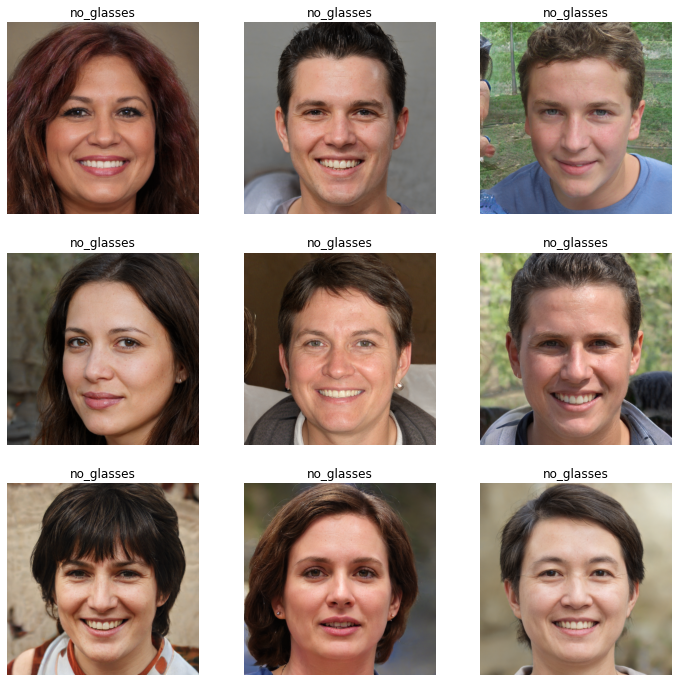

In [ ]:
with open("../input/datacleaningglassesnoglasses/no_glasses.txt", "rb") as fp:
    no_glasses = pickle.load(fp)
plt.figure(figsize=(12, 12))
ran_num = []
for i in range(0,9):
    n = random.randint(0,len(no_glasses))
    ran_num.append(n)
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(no_glasses[ran_num[i]]))
    plt.title("no_glasses")
    plt.axis("off")

## No clear:

Les données étant créées artificiellement, il peut y avoir des cas où il n'est pas clair si les photos appartiennent à la classe "glasses" ou "no_glasses"

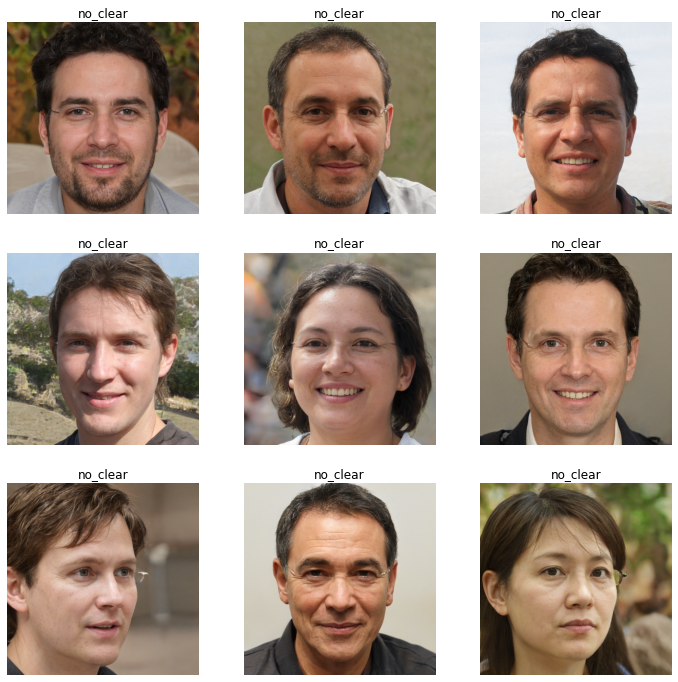

In [ ]:
with open("../input/datacleaningglassesnoglasses/no_clear.txt", "rb") as fp:
    no_clear = pickle.load(fp)
plt.figure(figsize=(12, 12))
ran_num = []
for i in range(0,9):
    n = random.randint(0,len(no_clear))
    ran_num.append(n)
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(no_clear[ran_num[i]]))
    plt.title("no_clear")
    plt.axis("off")

In [ ]:
print("The length of the different groups:" + "-Glasses: " + str(len(glasses)) + " -No glasses: " + str(len(no_glasses)) + " -No clear: " + str(len(no_clear)))

The length of the different groups:-Glasses: 2770 -No glasses: 2152 -No clear: 77


unbalanced data problem, avec beaucoup plus d'images de lunettes que d'images sans lunettes. D'autre part, 77 images ne seront pas utilisées dans le modèle car elles ne sont pas claires.

## The next model is based on Tensorflow/Learn/Tutorials/Images/Transfer learning and fine-tuning - https://www.tensorflow.org/tutorials

# 2) Data processing:

Donc un modèle de classification sera créé dans le but de classer des images de personnes avec des lunettes et sans lunettes.

random seed utilisé pour garantir meme random est appliquée

In [ ]:
tf.random.set_seed(123456)

Initialisation des parametres

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
all_images= glasses + no_glasses

In [ ]:
data_dir= "/kaggle/input/datacleaningglassesnoglasses/Images/Images/"

Split data
- 70% Training data
- 30% Validation data

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 4920 files belonging to 2 classes.
Using 3444 files for training.


In [ ]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 4920 files belonging to 2 classes.
Using 1476 files for validation.


train_dataset contient 4920 images et validation_datset 1476

In [ ]:
class_names = train_dataset.class_names
print(class_names)

['glasses', 'no_glasses']


Afficher des images depuis train dataset

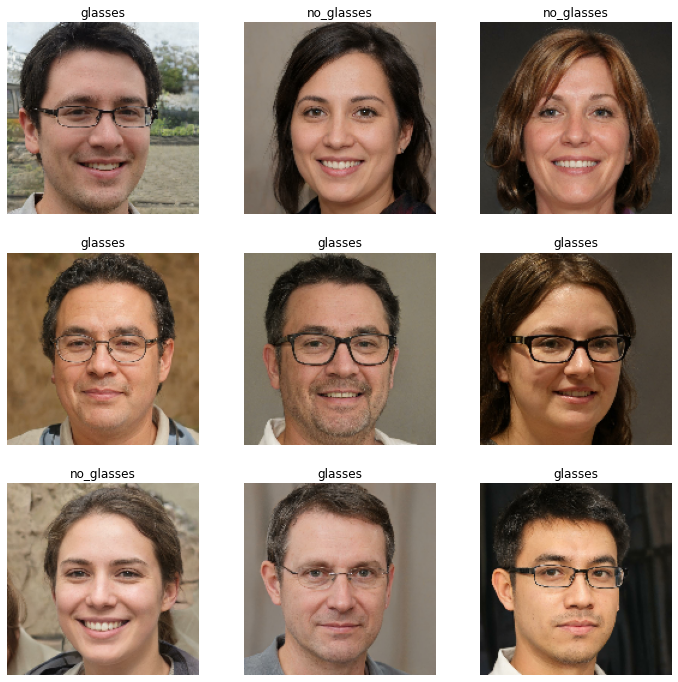

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Donc on train dataset et validation dataset. mais il est également important d'avoir les données de test pour évaluer le modèle. Cela constituera 20 % de l'ensemble de données de validation (validation_dataset), soit environ 6 %.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 108
Number of validation batches: 38
Number of test batches: 9


La fonction Dataset.prefetch() utilisée dans les trois ensembles de données (train, validation et test)

Cette configuration permet d'accélérer le processus d'entraînement du modèle.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# 3) Preparing base model:

## 3.1) Data augmentation¶

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### Below we can find the results of the data augmentation:

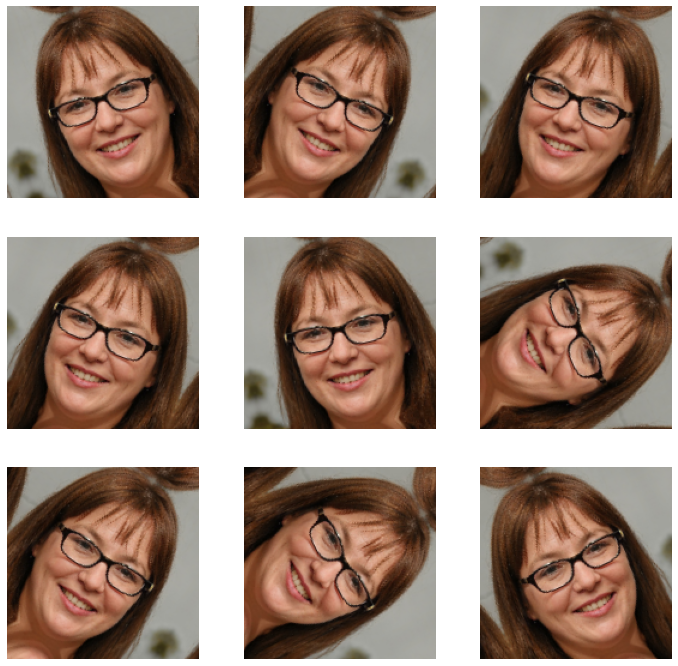

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## 3.2) Rescale pixel values:¶

Application de Mobilenet application de transfert learning pour utiliser un modele pré entrainé

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

This model expects `pixel values between -1 and 1`, hence the images should be `preprocessed`

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## 3.3) Création d'un modèle de base à partir de MobileNet V2.


Le modèle de base MobileNet V2 a été développé par Google. Il contient un grand ensemble de données avec 1,4 million d'images et 1000 classes.

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


### This feature extractor converts the images from `160x160x3` to `5x5x1280`

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 3.4) Feature extraction

Tout d'abord, nous devrions regler convolution base créée à partir de l'étape précédente, pour utilisé comme extracteur de caractéristique

In [ ]:
base_model.trainable = False

## 3.5) Adding classification head

La couche tf.keras.layers.GlobalAveragePooling2D va être utilisée pour convertir les caractéristiques en un vecteur de 1280 éléments pour chaque image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


tf.keras.layers.Dense qui convertit features en une prédiction unique

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


On va appliquer les etapes precedente
- `Data augmentation`
- `Rescaling`
- `Basel model`
- `Feature extractor`

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## 3.6) Compilation of the model:

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Il y a deux objets de variables, répartis entre environ 2,5 millions de paramètres de MobileNet qui sont gelés, et 1,2 millier de paramètres entraînables dans la couche Dense.

In [ ]:
len(model.trainable_variables)

2

## 3.7) Training the model

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

38/38 [==============================] - 16s 241ms/step - loss: 0.7179 - accuracy: 0.5691


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.59


In [ ]:
model_fit = model.fit(train_dataset,
                    epochs= initial_epochs,
                    validation_data= validation_dataset)

Epoch 1/10
108/108 [==============================] - 43s 364ms/step - loss: 0.6972 - accuracy: 0.6045 - val_loss: 0.6099 - val_accuracy: 0.6641
Epoch 2/10
108/108 [==============================] - 29s 260ms/step - loss: 0.5542 - accuracy: 0.7015 - val_loss: 0.5395 - val_accuracy: 0.7239
Epoch 3/10
108/108 [==============================] - 28s 247ms/step - loss: 0.4629 - accuracy: 0.7718 - val_loss: 0.4785 - val_accuracy: 0.7618
Epoch 4/10
108/108 [==============================] - 28s 246ms/step - loss: 0.3982 - accuracy: 0.8118 - val_loss: 0.4327 - val_accuracy: 0.8114
Epoch 5/10
108/108 [==============================] - 27s 242ms/step - loss: 0.3549 - accuracy: 0.8435 - val_loss: 0.3970 - val_accuracy: 0.8182
Epoch 6/10
108/108 [==============================] - 28s 244ms/step - loss: 0.3140 - accuracy: 0.8740 - val_loss: 0.3624 - val_accuracy: 0.8409
Epoch 7/10
108/108 [==============================] - 28s 245ms/step - loss: 0.2858 - accuracy: 0.8879 - val_loss: 0.3401 - val_ac

In [ ]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

In [ ]:
## 3.8) Results

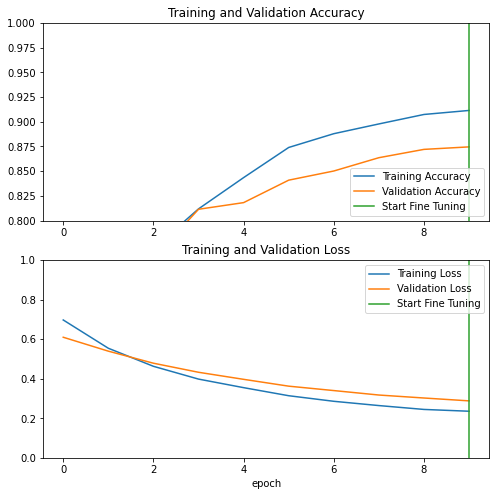

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Comme le montrent les graphiques, la précision sur les 10 époques était très similaire pour les échantillons de validation et d'entraînement. Cependant, il semble que, pour certaines époques, le modèle fonctionne légèrement mieux sur validation que sur l'entraînement.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)

108/108 [==============================] - 19s 167ms/step - loss: 0.2706 - accuracy: 0.8870
Test accuracy : 0.8993055820465088
Train accuracy : 0.8870499134063721


# 4) Model with fine tunning

Ce modèle est une continuation du "Modèle 1", cependant, un processus de "fine-tuning" sera appliqué pour augmenter les performances. Au cours du processus précédent, weights de mobilenet n'ont pas été mis à jour pendant l'entraînement. Cependant, il est possible d'augmenter les performances en appliquant ces poids.

## 4.1) Unfreeze the top layers of the model

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


## 4.2) Compile the model

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

56

## 4.3) Training the model

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

model_fit_fine = model.fit(train_dataset,
                         epochs= total_epochs,
                         initial_epoch= model_fit.epoch[-1],
                         validation_data= validation_dataset)

Epoch 10/15
108/108 [==============================] - 33s 252ms/step - loss: 0.1134 - accuracy: 0.9551 - val_loss: 0.0345 - val_accuracy: 0.9874
Epoch 11/15
108/108 [==============================] - 28s 248ms/step - loss: 0.0305 - accuracy: 0.9908 - val_loss: 0.0171 - val_accuracy: 0.9958
Epoch 12/15
108/108 [==============================] - 28s 245ms/step - loss: 0.0176 - accuracy: 0.9940 - val_loss: 0.0157 - val_accuracy: 0.9958
Epoch 13/15
108/108 [==============================] - 28s 246ms/step - loss: 0.0110 - accuracy: 0.9967 - val_loss: 0.0218 - val_accuracy: 0.9958
Epoch 14/15
108/108 [==============================] - 28s 246ms/step - loss: 0.0129 - accuracy: 0.9947 - val_loss: 0.0202 - val_accuracy: 0.9966
Epoch 15/15
108/108 [==============================] - 28s 243ms/step - loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.0185 - val_accuracy: 0.9958


In [ ]:
acc += model_fit_fine.history['accuracy']
val_acc += model_fit_fine.history['val_accuracy']
loss_ += model_fit_fine.history['loss']
val_loss_ += model_fit_fine.history['val_loss']

## 4.4) Results

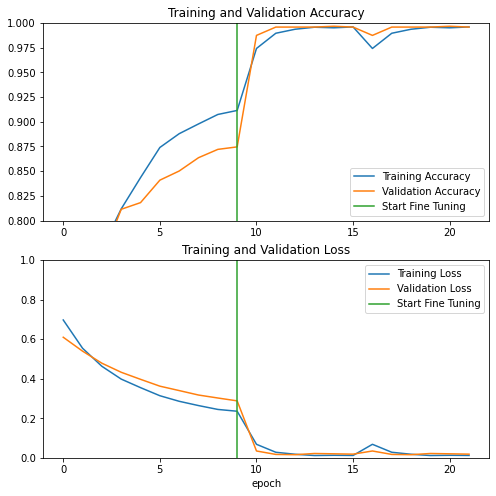

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
loss, accuracy2 = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)
print('Validation accuracy :', accuracy2)

38/38 [==============================] - 8s 140ms/step - loss: 0.0269 - accuracy: 0.9949
Test accuracy : 0.9965277910232544
Train accuracy : 0.9985482096672058
Validation accuracy : 0.9949495196342468



Comme on peut le voir dans entraînement et de test, la précision est très élevée, supérieure à 0,99. Cela signifie que ce modèle est robuste et fonctionne très bien.

# 5) Prediction

Dans ce cas, le "Modèle 2 avec fine-tuning" sera appliqué, car ses performances étaient meilleures. Les prédictions seront effectuées sur l'échantillon de test.

Predictions:
 [0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1]
Labels:
 [0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1]


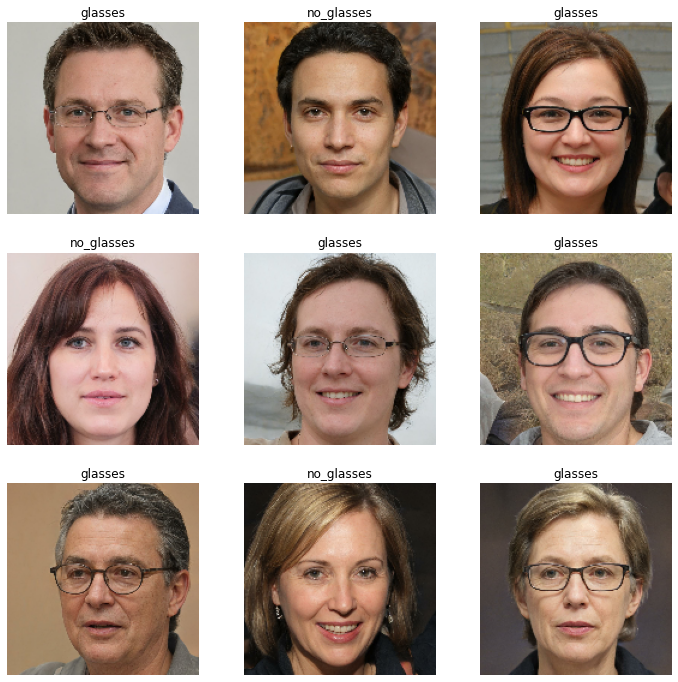

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

D'après les résultats, il semble que le modèle a classé parfaitement les images. Il est visible que le tableau de prédictions est identique aux étiquettes.





> Indented block

